In [14]:
import funcs
import torch
import torchvision as tv
import torchvision.transforms as transform
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import SGD,Adam
import torch.functional as F
from torch.utils.data import random_split,DataLoader
import itertools
import os
import networks
from torchsummary import summary
from tqdm.auto import tqdm
from torchmetrics.classification import Accuracy



In [15]:
device = funcs.get_GPU()
device
# Paths
PATH = '/Users/sai/Desktop/Paper'
IMAGE_SHAPE = (28,28)

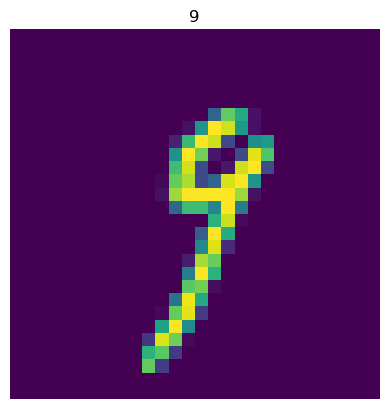

In [16]:
train_transform = transform.Compose([transform.ToTensor(),
                                     transform.Normalize((0.5,0.5),(0.5,0.5))]
)

test_transform = transform.Compose([transform.ToTensor(),
                                     transform.Normalize((0.5,0.5),(0.5,0.5))]
)

train_val_dataset = tv.datasets.MNIST(root=PATH,
                                      train=True,
                                      transform=transform.ToTensor(),
                                      download=True,target_transform=None)
test_dataset = tv.datasets.MNIST(root=PATH,
                                      train=False,
                                      transform=transform.ToTensor(),
                                      download=True,target_transform=None)

funcs.visualise(train_val_dataset)


In [17]:
total_size = len(train_val_dataset)
val_size = int(total_size * 0.05)
train_size =  total_size - val_size

train_subset,val_subset = random_split(train_val_dataset,[train_size,val_size])


train_dataloader = DataLoader(train_subset,batch_size=128,shuffle=True,num_workers=(os.cpu_count()//2))
val_loader = DataLoader(val_subset,batch_size=128,shuffle=False,num_workers=(os.cpu_count()//2))
test_loader = DataLoader(test_dataset,batch_size=128,shuffle=False,num_workers=(os.cpu_count()//2))

In [18]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student = 'checkpoints_student/'
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)

In [19]:
load_path = checkpoints_path_teacher  + 'Teacher_final.tar'
teacher_net = networks.TeacherModel()
teacher_net.load_state_dict(torch.load(load_path, map_location=device)['model_state_dict'])
teacher_net = teacher_net.to(device)

/var/folders/g5/l74v8ftn0kl2lzzq077xkvtw0000gn/T/ipykernel_31691/1936805873.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_net.load_state_dict(torch.load(load_p

In [20]:
_, test_accuracy = funcs.evaluate_model(teacher_net, test_loader, device)
print('teacher test accuracy: ', test_accuracy)

Epoch: 1, AVG Loss: 0.0004937030494009377, accuracy per epoch: 98.19
teacher test accuracy:  98.19


In [21]:
hparam = {'dropout_input': 0.0,
 'dropout_hidden': 0.0,
 'weight_decay': 1e-05,
 'lr_decay': 0.95,
 'momentum': 0.9, 'T':10, 'alpha':0.5,
 'lr': 0.01}

In [22]:
model = networks.StudentModel()
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 400]         314,000
              ReLU-4                  [-1, 400]               0
           Dropout-5                  [-1, 400]               0
            Linear-6                   [-1, 10]           4,010
Total params: 318,010
Trainable params: 318,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.21
Estimated Total Size (MB): 1.24
----------------------------------------------------------------


In [23]:
# Train Student (No Distillation)

epochs = 30
for epoch in range(epochs):
    train_loss, train_acc = funcs.train(model=model,dataset=train_dataloader,hparams=hparam,epoch=epoch,device=device)
    save_path = checkpoints_path_student +  'Student_final.tar'
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'loss': train_loss}, save_path)
    validation_loss,validation_acc = funcs.evaluate_model(model=model,dataset=val_loader,epoch=epoch,device=device)

Epoch: 1, training loss: 2.3033058643341064
Epoch: 1, training loss: 2.222846269607544
Epoch: 1, training loss: 2.054584264755249
Epoch: 1, training loss: 1.7740095853805542
Epoch: 1, training loss: 1.5638670921325684
Epoch: 1, training loss: 1.1885640621185303
Epoch: 1, training loss: 0.9681894183158875
Epoch: 1, training loss: 0.7337572574615479
Epoch: 1, training loss: 0.7949013113975525
Epoch: 1, training loss: 0.6570568084716797
Epoch: 1, training loss: 0.6716963648796082
Epoch: 1, training loss: 0.6363361477851868
Epoch: 1, training loss: 0.5092003345489502
Epoch: 1, training loss: 0.544259250164032
Epoch: 1, training loss: 0.6945809125900269
Epoch: 1, training loss: 0.5031902194023132
Epoch: 1, training loss: 0.44688647985458374
Epoch: 1, training loss: 0.4548795223236084
Epoch: 1, training loss: 0.572851300239563
Epoch: 1, training loss: 0.3868267238140106
Epoch: 1, training loss: 0.5647678971290588
Epoch: 1, training loss: 0.36388418078422546
Epoch: 1, training loss: 0.3149695

In [24]:

_ , test_accuracy = funcs.evaluate_model(model=model,dataset=test_loader,device=device)
print('test accuracy: ', test_accuracy)

Epoch: 1, AVG Loss: 0.0005337189677229616, accuracy per epoch: 97.89999999999999
test accuracy:  97.89999999999999


In [25]:
epochs = 30
for epoch in range(epochs):
    distilled_train_loss, distilled_train_acc = funcs.trainWithDistillation(student_model=model,
                                                                            teacher_model=teacher_net,
                                                                            dataset=train_dataloader,
                                                                            device=device,hparams=hparam,epochs=epoch)
    save_path = checkpoints_path_student +  'Student_distilled_final.tar'
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'loss': train_loss}, save_path)
    validation_loss,validation_acc = funcs.evaluate_model(model=model,dataset=val_loader,epoch=epoch,device=device)
    

Epoch: 1, training loss: 2.937333106994629
Epoch: 1, training loss: 1.092973232269287
Epoch: 1, training loss: 0.9933244585990906
Epoch: 1, training loss: 0.6217508912086487
Epoch: 1, training loss: 0.5439685583114624
Epoch: 1, training loss: 0.5036013126373291
Epoch: 1, training loss: 0.45455971360206604
Epoch: 1, training loss: 0.4791482090950012
Epoch: 1, training loss: 0.4120481610298157
Epoch: 1, training loss: 0.34272560477256775
Epoch: 1, training loss: 0.41373521089553833
Epoch: 1, training loss: 0.3402676284313202
Epoch: 1, training loss: 0.3139527440071106
Epoch: 1, training loss: 0.34303662180900574
Epoch: 1, training loss: 0.33405601978302
Epoch: 1, training loss: 0.31103694438934326
Epoch: 1, training loss: 0.2943563759326935
Epoch: 1, training loss: 0.32595589756965637
Epoch: 1, training loss: 0.34634092450141907
Epoch: 1, training loss: 0.3315255045890808
Epoch: 1, training loss: 0.2884809970855713
Epoch: 1, training loss: 0.30671682953834534
Epoch: 1, training loss: 0.2

In [26]:
_ , test_accuracy = funcs.evaluate_model(model=model,dataset=test_loader,device=device)
print('test accuracy: ', test_accuracy)

Epoch: 1, AVG Loss: 0.0004959960842039436, accuracy per epoch: 98.1
test accuracy:  98.1
